# Тестовое задание

Данные о крдетих и платежах.

## Задача
Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, ...

## Поля
+ order_id – номер заявки
+ created_at - дата создания заявки
+ put_at - дата выдачи
+ closed_at - дата закрытия
+ issued_sum - сумма выдачи
+ plan_at - дата планового платежа
+ plan_sum_total - сумма планового платежа (накопленным итогом)
+ paid_at - дата фактического платежа
+ paid_sum - сумма фактического платежа

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ORDERS_DF = pd.read_csv('data/orders.csv')
PAYMENTS_DF = pd.read_csv('data/payments.csv')
PLAN_DF = pd.read_csv('data/plan.csv')

ORDERS_DF['created_at'] = pd.to_datetime(ORDERS_DF['created_at'])
ORDERS_DF['put_at']     = pd.to_datetime(ORDERS_DF['put_at'])
ORDERS_DF['closed_at']  = pd.to_datetime(ORDERS_DF['closed_at'])

PAYMENTS_DF['paid_at']  = pd.to_datetime(PAYMENTS_DF['paid_at'])
PLAN_DF['plan_at']      = pd.to_datetime(PLAN_DF['plan_at'])

CURRENT_DATE = pd.to_datetime('2022-12-08') + pd.DateOffset(1)

ORDERS_DF.shape, PAYMENTS_DF.shape, PLAN_DF.shape

((55748, 5), (143284, 3), (420282, 3))

## Проверка
Перед работой с данными, проверим на несоответствия:
+ Корректность времени заявок и одобрений
+ Корректность времени одобрений и закрытие кредита
+ Соответствие суммы выплаченных средств с планом, если кредит закрыт

Часть результатов будет визуализированная в конце whitepepper

In [87]:
# Корректность времени заявок и одобрений
unusual_time_of_approve = ORDERS_DF.loc[ORDERS_DF['created_at'] > ORDERS_DF['put_at']]
unusual_time_of_approve
# В контесте задачи время одобрения данных заявок будет восприниматься как моментальное

,order_id,created_at,put_at,closed_at,issued_sum
10292,417505748,2022-06-18 16:48:56.997,2022-06-18,2022-09-25 16:21:48.107,5430.0
19860,434222763,2022-07-04 23:58:08.000,2022-07-04,2022-07-14 13:36:05.520,10000.0
22271,438243227,2022-07-08 23:59:09.000,2022-07-08,2022-07-19 20:05:45.207,2720.0
25964,444635761,2022-07-14 23:57:17.997,2022-07-14,2022-08-18 02:55:10.920,1000.0
28318,448752514,2022-07-18 15:06:58.997,2022-07-18,2022-07-26 12:06:16.623,3000.0
30490,452417146,2022-07-21 23:58:59.000,2022-07-21,2022-08-01 13:09:48.890,6790.0
31458,454039233,2022-07-23 15:23:54.000,2022-07-23,NaT,2720.0
33506,457523518,2022-07-26 22:00:55.000,2022-07-26,NaT,13600.0
33526,457548054,2022-07-26 22:57:56.997,2022-07-26,2022-08-05 10:59:05.460,2000.0
35452,460762380,2022-07-30 00:48:50.997,2022-07-30,NaT,13200.0


In [88]:
# Корректность времени одобрений и закрытие кредита + учетом предыдущей информации
unusual_time_of_close = ORDERS_DF.loc[
    (ORDERS_DF['closed_at'] < ORDERS_DF['created_at']) | (ORDERS_DF['closed_at'] < ORDERS_DF['put_at'])
    ]
unusual_time_of_close
# Подозрительная заявка возможна таже проблема как и в предыдущих

,order_id,created_at,put_at,closed_at,issued_sum
38182,465402852,2022-08-03 15:58:41,2022-08-13 17:40:26.047,2022-08-13,2000.0


In [89]:
print(PLAN_DF.loc[PLAN_DF['order_id'] == 465402852])
print(PAYMENTS_DF.loc[PAYMENTS_DF['order_id'] == 465402852])
# Дополнительная проверка показала отсутствие плана и фактических выплат
# Это либо ошибка БД, либо есть риск махинации

         order_id    plan_at  plan_sum_total
286972  465402852 2022-09-05             0.0
Empty DataFrame
Columns: [order_id, paid_at, paid_sum]
Index: []


In [90]:
# Поиск кредитов, для которых не установлен план выплат
total_sum = PLAN_DF.groupby('order_id')['plan_sum_total'].max()
total_sum.loc[total_sum == 0]
# Данный кредит был единственным

order_id
465402852    0.0
Name: plan_sum_total, dtype: float64

In [91]:
# Проверка ключей таблиц
print(set(ORDERS_DF['order_id'].unique()) - set(PLAN_DF['order_id'].unique()))
# Для каждого order_id из ORDERS_DF есть план, каким бы он не был.
zero_payments = set(ORDERS_DF['order_id'].unique()) - set(PAYMENTS_DF['order_id'].unique())
# print(zero_payments)
# Есть order_id из ORDERS_DF, у которых не было выплат

set()


In [92]:
ORDERS_DF.loc[(ORDERS_DF['order_id'].isin(zero_payments)) & (ORDERS_DF['closed_at'].notna())]
# Есть два кредитва, которые закрыты, а информации о выплатах нет.
# PLAN_DF.loc[PLAN_DF['order_id'] == 471890947]

,order_id,created_at,put_at,closed_at,issued_sum
38182,465402852,2022-08-03 15:58:41,2022-08-13 17:40:26.047,2022-08-13,2000.0
41944,471890947,2022-08-09 18:11:02,2022-09-01 14:14:17.930,2022-09-09,1000.0


In [93]:
# Корректность времени первого платежа
tmp = PAYMENTS_DF.merge(
    ORDERS_DF[['order_id', 'put_at', 'created_at']],
    on='order_id'
)
tmp.loc[(tmp['paid_at'] < tmp['put_at']) | (tmp['paid_at'] < tmp['created_at'])]
# У двух сделок есть информация только о дне, у одной несоответствие часа

,order_id,paid_at,paid_sum,put_at,created_at
3377,409391396,2022-06-12 00:00:00.000,8570.0,2022-06-12 11:27:48.320,2022-06-11 00:27:43.000
41689,455457680,2022-07-25 00:00:00.000,12120.0,2022-07-25 07:00:55.050,2022-07-25 06:53:26.997
46026,448637098,2022-07-28 14:23:59.997,18180.0,2022-07-28 15:46:45.430,2022-07-18 13:31:56.997


In [94]:
# Соответствие суммы выплаченных средств с планом, если кредит закрыт
closed = ORDERS_DF.loc[ORDERS_DF['closed_at'].notna(), 'order_id']

total_paid = PAYMENTS_DF.groupby('order_id', as_index=False)['paid_sum'].sum()
total_plan = PLAN_DF.groupby('order_id', as_index=False)['plan_sum_total'].max()

tmp = total_plan.merge(total_paid, on='order_id', how='left')
tmp = tmp.merge(ORDERS_DF[['order_id', 'issued_sum']], on='order_id', how='left')

tmp.loc[
    (tmp['order_id'].isin(closed)) & 
    (tmp['plan_sum_total'] > tmp['paid_sum'])
    ]
# 16917 кредитов, которые закрыты, но выплаченная сумма меньше необходимой
# Нужно обратить внимание, что выплаченные средства больше взятой в долг, т.е. не выплачена цена кредита
tmp.loc[
    (tmp['order_id'].isin(closed)) & 
    (tmp['plan_sum_total'] > tmp['paid_sum']) & 
    (tmp['issued_sum'] > tmp['paid_sum'])
    ]
# Три кредита закрыты до выплаты полученных средств.
# Все найденные таким образом кредиты можно интрепретировать как списанные, т.е. убыток.

,order_id,plan_sum_total,paid_sum,issued_sum
30929,453159594,10350.0,9090.0,13200.0
39046,466931138,11500.0,10100.0,14600.0
43529,474563400,9200.0,8480.0,11680.0


In [95]:
# Кредиты у которых время закрытия не совпадает с фактическим временем закрытия
# В дальнейшем учет времени закрытия кредита будет определяться по последниму платежу
tmp = ORDERS_DF.merge(PAYMENTS_DF.groupby('order_id')['paid_at'].max(), how='left', on='order_id').merge(PLAN_DF.groupby('order_id')['plan_at'].max(), how='left', on='order_id')
tmp.loc[(tmp['closed_at'] != tmp['paid_at']) & (tmp['closed_at'].notna()), ['order_id', 'closed_at', 'paid_at', 'plan_at']]

,order_id,closed_at,paid_at,plan_at
274,400438418,2022-06-03 10:53:00.000,2022-06-02 16:02:20.057,2022-07-03
581,400973198,2022-06-09 18:33:00.000,2022-06-03 00:00:00.000,2022-06-17
902,401467534,2022-06-14 00:00:00.000,2022-06-06 00:00:00.000,2022-06-18
1042,401698023,2022-06-13 00:00:00.000,2022-06-09 00:00:00.000,2022-06-18
2906,404915926,2022-07-15 19:04:00.000,2022-07-11 00:00:00.000,2022-07-19
3154,405347008,2022-07-08 10:36:11.230,2022-07-07 19:21:13.917,2022-12-04
3210,405444022,2022-06-07 18:13:00.000,2022-06-07 13:38:18.927,2022-06-22
3913,406677383,2022-06-20 00:00:00.000,2022-06-09 00:00:00.000,2022-06-23
13233,422512430,2022-07-19 13:46:18.470,2022-07-06 00:00:00.000,2022-07-20
14063,423939156,2022-07-07 13:13:16.593,2022-07-07 00:00:00.000,2022-07-09


### Краткая сводка

1. Есть несколько заявок с некорректным временем одобрения по шаблону.
2. 2 заявки закрыты и никаких выплат не происходило (465402852, 471890947).
3. 3 сделки с преждевременной выплатой, две из которых по шаблону.
4. Часть сделок закрыты по списанию.

Визуализация убытков будет в конце whitepepper.

## Введение дополнительных метрик
Основная задача проверить поведение выплат. Для этого стоит предварительно определить и ввести следующие метрики.
+ Относительная и абсолютная стоимость кредита.
+ Время одобрения заявки.

Верхние два пункта могут оказать влияние при оценке рисков. С учётом доступных сведений. Кроме того, могут помочь интрепретировать уже полученные результаты анализа просрочек/досрочных погашений.

+ Индикатор досрочного погашения и характеристика досрочного погашения.
+ Индикатор наличия просрочек с их описательной характеристикой для каждого кредита.

Следующие метрики могут помочь определить глобальные тренды.

+ Общий объем задолженностей, выплат
+ Ежемесячная сумма выплат, задоженностей
+ Количество одобренных заявок в месяц.

In [96]:
ORDERS_DF = ORDERS_DF.merge(
        PLAN_DF.groupby('order_id', as_index=False).agg(
            plan_sum_total=('plan_sum_total', 'max'),
            n_plan_payments=('plan_sum_total', 'count')
            ), on='order_id', how='left'
    )
ORDERS_DF = ORDERS_DF.merge(
        PAYMENTS_DF.groupby('order_id', as_index=False).agg(
            paid_sum_total=('paid_sum', 'sum'),
            n_real_payments=('paid_sum', 'count')
            ), on='order_id', how='left'
    )

In [97]:
# Ввод метрик общей информации о кредите
ORDERS_DF['credit_cost_abs'] = np.round(ORDERS_DF['plan_sum_total'] - ORDERS_DF['issued_sum'])
ORDERS_DF['credit_cost_rel'] = np.round(ORDERS_DF['plan_sum_total'] / ORDERS_DF['issued_sum'] - 1, 2)
ORDERS_DF['acceptance_time'] = ORDERS_DF['put_at'] - ORDERS_DF['created_at']
ORDERS_DF.loc[ORDERS_DF['acceptance_time'] < pd.Timedelta(0), 'acceptance_time'] = pd.Timedelta(0)

# Устанавливаем фактическую дату закрытия
# Если платеж закрывающий кредит, еще не обработан, то назанчаем real_closed_at
ORDERS_DF['real_closed_at'] = np.where(
    (ORDERS_DF['closed_at'].notna()) | (ORDERS_DF['plan_sum_total'] == ORDERS_DF['paid_sum_total']),
    ORDERS_DF.merge(
        PAYMENTS_DF.groupby('order_id')['paid_at'].max(), 
        how='left', on='order_id'
    )['paid_at'],
    pd.to_datetime(np.nan)
)
ORDERS_DF['real_closed_at'] = pd.to_datetime(ORDERS_DF['real_closed_at'])

ORDERS_DF

,order_id,created_at,put_at,closed_at,issued_sum,plan_sum_total,n_plan_payments,paid_sum_total,n_real_payments,credit_cost_abs,credit_cost_rel,acceptance_time,real_closed_at
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,23050.00,7,23050.00,7.0,9450.0,0.69,0 days 20:17:36.183000,2022-10-17 11:52:22.190
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0,23000.00,1,20200.00,1.0,3000.0,0.15,0 days 15:31:10.270000,2022-06-02 17:38:43.917
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0,8579.10,13,8579.10,2.0,2759.0,0.47,3 days 18:59:34.547000,2022-06-21 21:55:51.877
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0,12628.36,1,12628.36,1.0,3628.0,0.40,1 days 14:03:11.033000,2022-07-12 10:47:46.307
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0,6013.70,1,6013.70,1.0,1014.0,0.20,0 days 00:15:01.320000,2022-06-22 14:15:07.423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55743,495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaT,9500.0,16553.89,13,2500.00,1.0,7054.0,0.74,0 days 00:37:54.307000,NaT
55744,495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0,21243.04,13,21243.04,3.0,6313.0,0.42,4 days 18:09:21.006000,2022-09-16 18:36:09.857
55745,495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0,4600.00,1,4320.00,1.0,600.0,0.15,0 days 00:17:47.013000,2022-09-09 21:08:18.970
55746,495176080,2022-08-31 23:47:20.997,2022-08-31 23:49:03.027,2022-09-12 00:58:57.037,5000.0,5750.00,1,5600.00,1.0,750.0,0.15,0 days 00:01:42.030000,2022-09-12 00:58:57.037


In [98]:
# Представление динамики погашения кредитов, со статусами
# Статусы облегчат дальнейшую работу по анализу/визулизацию
view = PLAN_DF.merge(
    PAYMENTS_DF,
    on='order_id',
    how='left'
).merge(ORDERS_DF[['order_id', 'real_closed_at']], how='left', on='order_id')

tmp = view.copy()

tmp['cum_sum'] = tmp.groupby(
        ['order_id', 'plan_at'], as_index=False
    )['paid_sum'].cumsum()

best_agg = tmp.groupby(
        ['order_id', 'plan_at'], as_index=False
    ).agg(
        first_cover_payment=('paid_at', 'last'),
        plan_sum_total=('plan_sum_total', 'first')
    )

coverage = tmp[
        tmp['cum_sum'] >= tmp['plan_sum_total']
    ].groupby(
        ['order_id', 'plan_at'], as_index=False
    ).agg(
        first_cover_payment=('paid_at', 'min')
    )

coverage = best_agg.merge(
        coverage,
        on=['order_id', 'plan_at'],
        how='left'
    )

coverage['first_cover_payment'] = np.where(
    coverage['first_cover_payment_y'].isna(),
    coverage['first_cover_payment_x'],
    coverage['first_cover_payment_y']
)
coverage.drop(['first_cover_payment_x', 'first_cover_payment_y'], axis=1, inplace=True)

view = view.merge(coverage, how='left', on=['order_id', 'plan_at'])
view['plan_sum_total'] = view['plan_sum_total_x']
view.drop(['plan_sum_total_x', 'plan_sum_total_y'], axis=1, inplace=True)


view = view.merge(view.loc[view['paid_at'] < view['plan_at'] + pd.DateOffset(1)].groupby(
        ['order_id', 'plan_at'], as_index=False
    ).agg(paid_total=('paid_sum', 'sum')), on=['order_id', 'plan_at'], how='left')
view['paid_total'] = view['paid_total'].fillna(0)
view.drop(['paid_at', 'paid_sum'], axis=1, inplace=True)
view = view.drop_duplicates(['order_id', 'plan_at'])
view['debt'] = np.round(view['plan_sum_total'] - view['paid_total'], 2)

orders_deadlines = PLAN_DF.groupby('order_id')['plan_at'].max()

# для каждой записи генерируется статус
# expired - платеж просрочен
# discarded - платеж просрочен и списан
# completed - платеж выполнен
# closed - платеж не нужен по причине закрытия кредита
# upcoming - платеж предстоит

view['status'] = np.select(
    condlist=[
        # closed
        (view['debt'] <= 0) & (view['real_closed_at'] < view['plan_at'] + pd.DateOffset(1)),
        # discarded
        (
            view['real_closed_at'].notna() & 
            (view['real_closed_at'] < view['plan_at'] + pd.DateOffset(1)) & 
            (view['debt'] > 0)
        ),
        # completed
        (view['debt'] <= 0),
        # upcoming
        (view['real_closed_at'].isna() & (CURRENT_DATE <= view['plan_at'] + pd.DateOffset(1))),
        # expired
        (view['debt'] > 0)
    ],
    choicelist=[
        'closed',
        'discarded',
        'completed',
        'upcoming',
        'expired'
    ],
    default='unknown'
)

view[view['status']=='unknown']

,order_id,plan_at,real_closed_at,first_cover_payment,plan_sum_total,paid_total,debt,status


In [99]:
# 400014330 400001732 495177509 400039450 400014289 400682549
# 400117056 400123081 400231132 413853839 426614065 470562713
# 400009027 400008952 431262524	459550163 460652970	400010534	
# 400117056 400010534

# var = 470562713
# view[view['order_id'] == var]
# PLAN_DF[PLAN_DF['order_id']==var]
# PAYMENTS_DF[PAYMENTS_DF['order_id']==var]

### Добавление метрик опрежений/задержек

In [100]:
view.loc[view['status'].isin(['expired', 'discarded']), 'expired_delay'] = (
    view['first_cover_payment'] - (view['plan_at'] + pd.DateOffset(1))
    )
view.loc[view['status'].isin(['completed', 'closed']), 'overpayment_delay'] = (
    view['plan_at'] + pd.DateOffset(1) - view['first_cover_payment']
    )
view

,order_id,plan_at,real_closed_at,first_cover_payment,plan_sum_total,paid_total,debt,status,expired_delay,overpayment_delay
0,400001732,2022-06-02,2022-10-17 11:52:22.190,2022-06-02 20:20:16.790,5600.00,5600.00,0.00,completed,NaT,0 days 03:39:43.210000
7,400001732,2022-07-02,2022-10-17 11:52:22.190,2022-06-16 16:05:26.007,9450.00,9450.00,0.00,completed,NaT,16 days 07:54:33.993000
14,400001732,2022-08-01,2022-10-17 11:52:22.190,2022-07-15 12:32:34.087,12170.00,12170.00,0.00,completed,NaT,17 days 11:27:25.913000
21,400001732,2022-08-31,2022-10-17 11:52:22.190,2022-08-16 12:38:01.237,14890.00,14890.00,0.00,completed,NaT,15 days 11:21:58.763000
28,400001732,2022-09-30,2022-10-17 11:52:22.190,2022-09-15 12:14:48.867,17610.00,20330.00,-2720.00,completed,NaT,15 days 11:45:11.133000
...,...,...,...,...,...,...,...,...,...,...
1483538,495177509,2022-12-22,NaT,2022-10-23 15:21:43.243,34248.70,36863.04,-2614.34,completed,NaT,60 days 08:38:16.757000
1483548,495177509,2023-01-06,NaT,2022-10-24 13:10:53.557,36863.04,36863.04,0.00,completed,NaT,74 days 10:49:06.443000
1483558,495177509,2023-01-21,NaT,2022-10-24 13:10:53.557,39440.38,36863.04,2577.34,upcoming,NaT,NaT
1483568,495177509,2023-02-05,NaT,2022-10-24 13:10:53.557,41980.73,36863.04,5117.69,upcoming,NaT,NaT


### Метрики кредитов

In [101]:
ORDERS_DF = ORDERS_DF.set_index('order_id')

# Положительно хорошо, отрицательно плохо
closing_delta = (
        view.groupby('order_id')['plan_at'].max()
        + pd.DateOffset(1)
        - view.set_index('order_id')['real_closed_at'].drop_duplicates()
    )

ORDERS_DF['closing_delta'] = closing_delta

ORDERS_DF = ORDERS_DF.join(
    [
        view[view['status'].isin(['completed', 'closed'])].groupby('order_id').agg(
            mean_overpayment=('debt', 'mean'),
            mean_overpayment_delay=('overpayment_delay', 'mean')
        ),
        view[view['status'].isin(['expired', 'discarded'])].groupby('order_id').agg(
            mean_debt=('debt', 'mean'),
            mean_expired_delay=('expired_delay', 'mean')
        ),
        view.groupby('order_id').agg(
            n_expired=('debt', 'count'),
            n_completed=('expired_delay', 'count')
        ),
    ],
    how='left'
)

ORDERS_DF['closing_time'] = np.where(
    ORDERS_DF['closed_at'].isna() & ORDERS_DF['real_closed_at'].notna(),
    CURRENT_DATE - ORDERS_DF['real_closed_at'],
    ORDERS_DF['closed_at'] - ORDERS_DF['real_closed_at']
)

ORDERS_DF

,created_at,put_at,closed_at,issued_sum,plan_sum_total,n_plan_payments,paid_sum_total,n_real_payments,credit_cost_abs,credit_cost_rel,acceptance_time,real_closed_at,closing_delta,mean_overpayment,mean_overpayment_delay,mean_debt,mean_expired_delay,n_expired,n_completed,closing_time
order_id,,,,,,,,,,,,,,,,,,,,
400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,23050.00,7,23050.00,7.0,9450.0,0.69,0 days 20:17:36.183000,2022-10-17 11:52:22.190,43 days 12:07:37.810000,-777.142857,20 days 06:01:40.027428571,NaN,NaT,7,0,0 days
400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0,23000.00,1,20200.00,1.0,3000.0,0.15,0 days 15:31:10.270000,2022-06-02 17:38:43.917,15 days 06:21:16.083000,NaN,NaT,2800.000000,-16 days +17:38:43.917000,1,1,0 days
400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0,8579.10,13,8579.10,2.0,2759.0,0.47,3 days 18:59:34.547000,2022-06-21 21:55:51.877,164 days 02:04:08.123000,-2425.004167,81 days 16:17:16.408000,910.000000,0 days 21:55:51.877000,13,1,0 days
400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0,12628.36,1,12628.36,1.0,3628.0,0.40,1 days 14:03:11.033000,2022-07-12 10:47:46.307,-24 days +13:12:13.693000,NaN,NaT,12628.360000,23 days 10:47:46.307000,1,1,0 days
400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0,6013.70,1,6013.70,1.0,1014.0,0.20,0 days 00:15:01.320000,2022-06-22 14:15:07.423,-5 days +09:44:52.577000,NaN,NaT,6013.700000,4 days 14:15:07.423000,1,1,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaT,9500.0,16553.89,13,2500.00,1.0,7054.0,0.74,0 days 00:37:54.307000,NaT,NaT,0.000000,0 days 23:50:39.200000,6075.984286,-53 days +00:09:20.800000,13,7,NaT
495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0,21243.04,13,21243.04,3.0,6313.0,0.42,4 days 18:09:21.006000,2022-09-16 18:36:09.857,161 days 05:23:50.143000,-6786.377273,86 days 05:23:50.143000,2947.500000,3 days 06:37:28.778000,13,2,0 days
495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0,4600.00,1,4320.00,1.0,600.0,0.15,0 days 00:17:47.013000,2022-09-09 21:08:18.970,7 days 02:51:41.030000,NaN,NaT,280.000000,-8 days +21:08:18.970000,1,1,0 days


# Графики

## Общие показатели

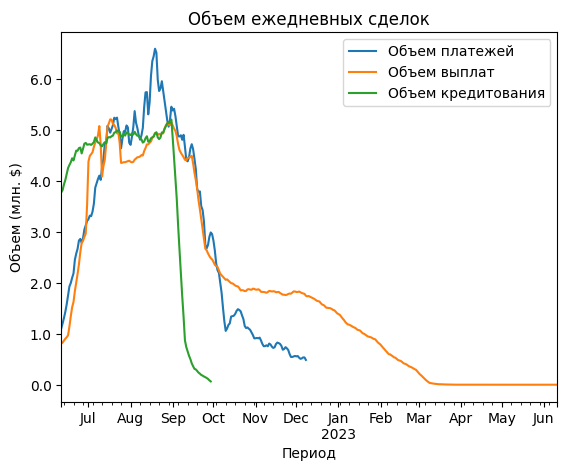

In [114]:
window=10
PAYMENTS_DF_COPY = PAYMENTS_DF.copy()
PLAN_DF_COPY = PLAN_DF.copy()
ORDERS_DF_COPY = ORDERS_DF.copy()

PAYMENTS_DF_COPY['paid_at'] = PAYMENTS_DF_COPY['paid_at'].dt.to_period('D')
PLAN_DF_COPY['plan_at'] = PLAN_DF_COPY['plan_at'].dt.to_period('D')
ORDERS_DF_COPY['put_at'] = ORDERS_DF_COPY['put_at'].dt.to_period('D')

PLAN_DF_COPY['plan_sum'] = PLAN_DF_COPY.groupby('order_id')['plan_sum_total'].diff()
PLAN_DF_COPY['plan_sum'] = PLAN_DF_COPY['plan_sum'].fillna(PLAN_DF_COPY['plan_sum_total'])

PAYMENTS_DF_COPY = PAYMENTS_DF_COPY.groupby('paid_at')['paid_sum'].sum()
PLAN_DF_COPY = PLAN_DF_COPY.groupby('plan_at')['plan_sum'].sum()
ORDERS_DF_COPY = ORDERS_DF_COPY.groupby('put_at')['issued_sum'].sum()

plt.title('Объем ежедневных сделок')
PAYMENTS_DF_COPY.rolling(window).mean().dropna().plot(label='Объем платежей')
PLAN_DF_COPY.rolling(window).mean().dropna().plot(label='Объем выплат')
ORDERS_DF_COPY.rolling(window).mean().dropna().plot(label='Объем кредитования')
plt.xlabel('Период')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e6}'))
plt.ylabel('Объем (млн. $)')
plt.legend()
plt.show()
# Объём платежей по обязательствам имеет пик в конце сентября 
# С начала сентября все паказатели имеют тенденцию снижаться

/tmp/ipykernel_5863/3244479916.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(PAYMENTS_DF_COPY.groupby('paid_at')['paid_sum'].mean()).set_xticklabels(['Пн', "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])


Text(0.5, 1.0, 'Распределение объема выплат по дням недели')

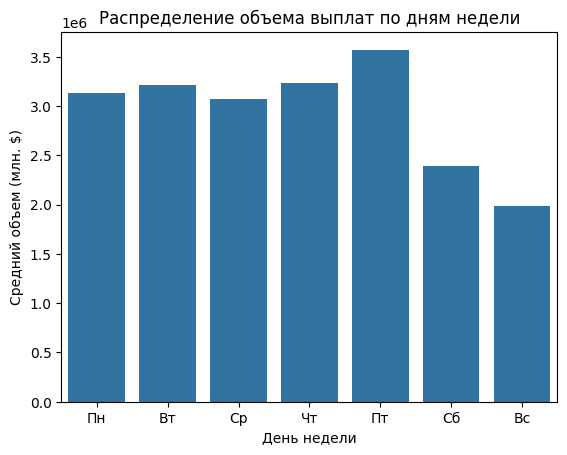

In [ ]:
PAYMENTS_DF_COPY = PAYMENTS_DF_COPY.reset_index()
PAYMENTS_DF_COPY['paid_at'] = PAYMENTS_DF_COPY['paid_at'].dt.dayofweek
sns.barplot(PAYMENTS_DF_COPY.groupby('paid_at')['paid_sum'].mean()).set_xticklabels(['Пн', "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.xlabel('День недели')
plt.ylabel('Средний объем (млн. $)')
plt.title('Распределение объема выплат по дням недели')
# В выходные дни фиксируется спад количества платежей
# В пт происходит наибольшее поступление средств.

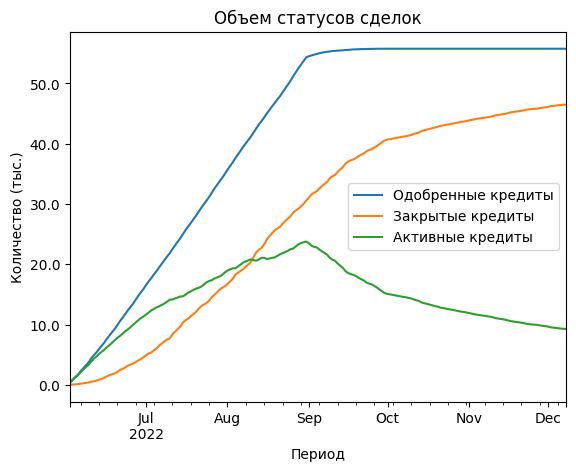

In [104]:
window = 5
plt.title('Объем статусов сделок')
tmp = ORDERS_DF.copy()
tmp['put_at'] = tmp['put_at'].dt.to_period('D')
tmp['closed_at'] = tmp['closed_at'].dt.to_period('D')

approved = tmp.groupby('put_at')['put_at'].count().cumsum()
closed = tmp.dropna(subset=['closed_at']).groupby('closed_at')['closed_at'].count().cumsum()
all = pd.concat([closed, approved], axis=1)
all['put_at'] = all['put_at'].fillna(all['put_at'].max())
all['active'] = all['put_at'] - all['closed_at']

all['put_at'].plot(label='Одобренные кредиты')
all['closed_at'].plot(label='Закрытые кредиты')
all['active'].plot(label='Активные кредиты')

plt.xlabel('Период')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e3}'))
plt.ylabel('Количество (тыс.)')

plt.legend()
# Вплоть до сентября количество одобренных кредитов растет стабильно,
# далее динамика прекращается из-за чего падает количество активных кредитов

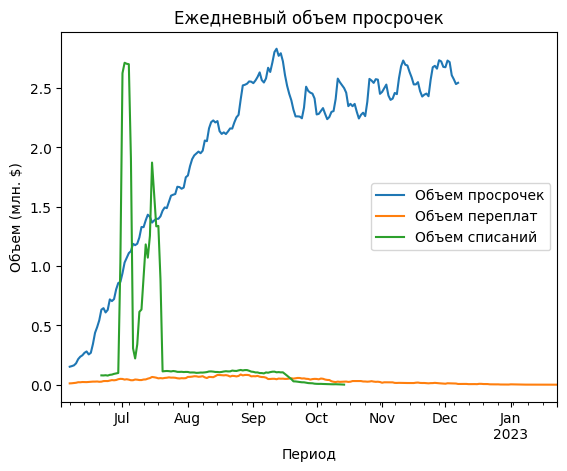

In [105]:
plt.title('Ежедневный объем просрочек')
view[view['status']=='expired'].groupby('plan_at')['debt'].sum().rolling(window).mean().plot(label='Объем просрочек')
abs(view[view['status']=='completed'].groupby('plan_at')['debt'].sum()).rolling(window).mean().plot(label='Объем переплат')
view[view['status']=='discarded'].groupby('plan_at')['debt'].sum().rolling(window).mean().plot(label='Объем списаний')

plt.xlabel('Период')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e6}'))
plt.ylabel('Объем (млн. $)')

plt.legend()
plt.show()
# На протяжении всего июля наблюдается большое количество кредитов, со списанием
# Ежедневный общий объем просрочек к середине сентября растет

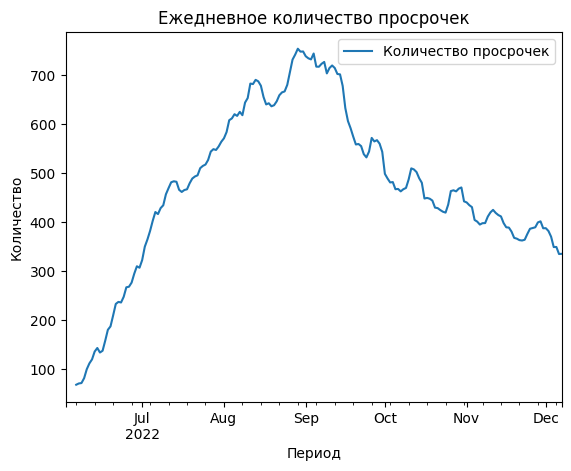

In [106]:
plt.title('Ежедневное количество просрочек')
view[view['status']=='expired'].groupby('plan_at')['debt'].count().rolling(window).mean().plot(label='Количество просрочек')

plt.xlabel('Период')
plt.ylabel('Количество')

plt.legend()
plt.show()
# Ежедневное количество просрочек к середине сентября растет
# далее идет их спад.
# Одновременно с этим объем в $ остается на относительно стабильном уровне.

/tmp/ipykernel_5863/3948492063.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(tmp.groupby('plan_at')['debt'].mean()).set_xticklabels(['Пн', "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])


Text(0.5, 1.0, 'Распределение просрочек по дням недели')

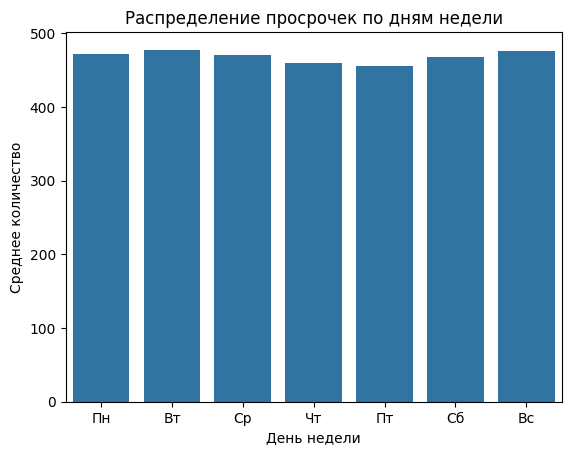

In [ ]:
tmp = view[view['status']=='expired'].groupby('plan_at')['debt'].count()
tmp = tmp.reset_index()
tmp['plan_at'] = tmp['plan_at'].dt.dayofweek
sns.barplot(tmp.groupby('plan_at')['debt'].mean()).set_xticklabels(['Пн', "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.xlabel('День недели')
plt.ylabel('Среднее количество')
plt.title('Распределение просрочек по дням недели')


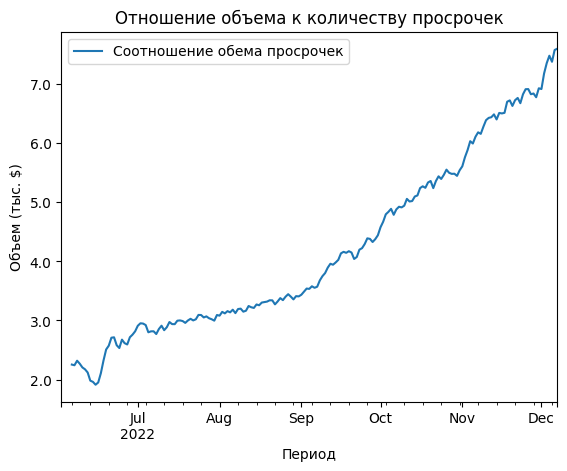

In [107]:
plt.title('Отношение объема к количеству просрочек')

((view[view['status']=='expired'].groupby('plan_at')['debt'].sum()/
 view[view['status']=='expired'].groupby('plan_at')['debt'].count())
.rolling(window).mean().plot(label='Соотношение обема просрочек'))

plt.xlabel('Период')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e3}'))
plt.ylabel('Объем (тыс. $)')

plt.legend()
plt.show()

In [108]:
# Кредиты под списание имеют один плановый платеж
PLAN_DF.value_counts('order_id')[view.loc[view['status']=='discarded', 'order_id']].max()

np.int64(1)

## Сводка по кредитам

In [109]:
tmp = ORDERS_DF[
    ['issued_sum', 
    'credit_cost_rel',
    'acceptance_time',
    'closing_delta',
    'mean_overpayment_delay',
    'mean_debt',
    'mean_expired_delay',
    'closing_time']
].describe()

print(
    f' Среднее тело кредита: ${tmp.loc['mean', 'issued_sum']:.2f}\n',
    f'Средний процент стоимости : {tmp.loc['mean', 'credit_cost_rel']:.2f}%\n',
    f'Среднее время одобрения: {tmp.loc['mean', 'acceptance_time']}\n',
    f'Среднее время закрытия: {tmp.loc['mean', 'closing_delta']}\n',
    f'Среднее время опережения плана: {tmp.loc['mean', 'mean_overpayment_delay']}\n',
    f'Средняя неуплата: ${tmp.loc['mean', 'mean_debt']:.2f}\n',
    f'Среднее время задержки: {abs(tmp.loc['mean', 'mean_expired_delay'])}\n',
    f'Среднее время подтверждения закрытия: {tmp.loc['mean', 'closing_time']}\n',
)


 Среднее тело кредита: $7907.20
 Средний процент стоимости : 0.51%
 Среднее время одобрения: 2 days 15:54:41.313789140
 Среднее время закрытия: 74 days 01:22:44.268362646
 Среднее время опережения плана: 43 days 18:50:48.995091944
 Средняя неуплата: $3038.45
 Среднее время задержки: 2 days 11:32:39.009073949
 Среднее время подтверждения закрытия: 0 days 00:05:49.719081125



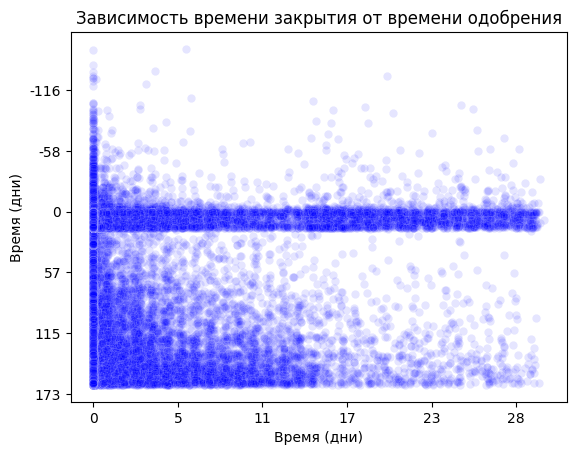

In [110]:
sns.scatterplot(ORDERS_DF, x='acceptance_time', y='closing_delta', alpha=0.1, color='blue')
plt.title("Зависимость времени закрытия от времени одобрения")
plt.xlabel('Время (дни)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{pd.Timedelta(x).days}'))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{pd.Timedelta(x).days}'))
plt.ylabel('Время (дни)')
plt.show()

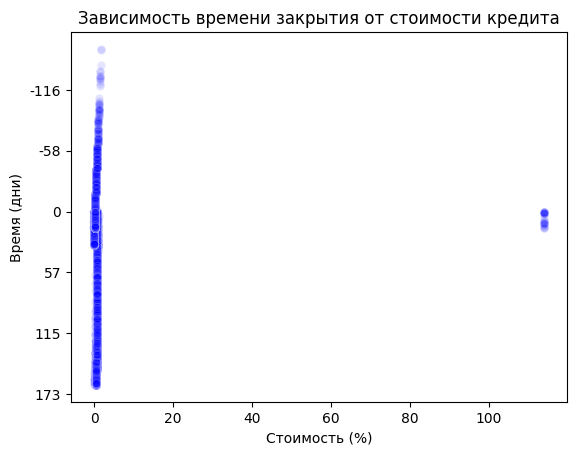

-0.554176009397297

In [111]:
sns.scatterplot(ORDERS_DF, x='credit_cost_rel', y='closing_delta', alpha=0.1, color='blue')
plt.title("Зависимость времени закрытия от стоимости кредита")
plt.xlabel('Стоимость (%)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{pd.Timedelta(x).days}'))
plt.ylabel('Время (дни)')
plt.show()
tmp = ORDERS_DF.copy()
tmp = tmp[(tmp['credit_cost_rel']<=100)]
float(np.corrcoef(tmp['credit_cost_rel'], tmp['closing_delta'].astype(int))[0, 1])